<a href="https://colab.research.google.com/github/athens-igg/dfu-models/blob/main/mobilenet%2BQPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 715.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 138.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()   # select kaggle.json

Saving kaggle (18).json to kaggle (18).json


{'kaggle (18).json': b'{"username":"athenkaggle","key":"516b1834a479eda2c9944d17506a9dcd"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp "kaggle (18).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 2.31GB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [ ]:
!unzip -q dfu-wagners-classification.zip -d /content/drive

In [ ]:
input_train_data="/content/drive/Dataset/Training"
qpso_train_data="/content/drive/qpso_Dataset/QPSO_Training"

input_valid_data="/content/drive/Dataset/Validation"
qpso_valid_data="/content/drive/qpso_Dataset/qpso_Validation"

In [ ]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 27.2 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def qpso_segmentation(image, max_iter=30, swarm_size=15):
    # --- QPSO Implementation (Otsu-based fitness) ---
    def fitness(image, threshold):
        # Otsu’s between-class variance
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    particles = np.random.randint(1,255,(swarm_size,))
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]

    for _ in range(max_iter):
        mbest = np.mean(pbest)
        for i in range(swarm_size):
            phi = np.random.rand()
            p = phi*pbest[i] + (1-phi)*gbest
            u = np.random.rand()
            beta = 1.0
            new_particle = p + beta*np.sign(u-0.5)*np.abs(mbest - particles[i])*np.log(1.0/u)
            new_particle = int(np.clip(new_particle, 1, 254))

            f = fitness(image, new_particle)
            if f > pbest_fitness[i]:
                pbest[i] = new_particle
                pbest_fitness[i] = f
                if f > max(pbest_fitness):
                    gbest = new_particle
        particles = pbest.copy()

    return gbest






In [ ]:
def process_training_dataset(input_train_data, qpso_train_data):
    for cls in os.listdir(input_train_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path = os.path.join(input_train_data, cls)
        output_path = os.path.join(qpso_train_data, cls)
        os.makedirs(output_path, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            img_path = os.path.join(input_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            best_thresh = qpso_segmentation(img)
            _, segmented = cv2.threshold(img, best_thresh, 255, cv2.THRESH_BINARY)


            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path = os.path.join(output_path, img_name)
            cv2.imwrite(save_path, segmented_rgb)

        print(f"✅ Finished QPSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path}")



In [ ]:
# Example usage
input_train_data="/content/drive/Dataset/Training"
qpso_train_data="/content/drive/qpso_Dataset/QPSO_Training"
process_training_dataset(input_train_data, qpso_train_data)

Processing Grade 1 ...


100%|██████████| 141/141 [00:04<00:00, 30.53it/s]


✅ Finished QPSO Segmentation for Grade 1.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 1
Processing Grade 0 ...


100%|██████████| 53/53 [00:01<00:00, 30.13it/s]


✅ Finished QPSO Segmentation for Grade 0.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 557/557 [00:18<00:00, 29.52it/s]


✅ Finished QPSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 152/152 [00:04<00:00, 30.57it/s]


✅ Finished QPSO Segmentation for Grade 2.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 2
Processing Grade 3 ...


100%|██████████| 62/62 [00:02<00:00, 30.49it/s]

✅ Finished QPSO Segmentation for Grade 3.
   Saved in: /content/drive/qpso_Dataset/QPSO_Training/Grade 3


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def qpso_segmentation(image, max_iter=30, swarm_size=15):
    # --- QPSO Implementation (Otsu-based fitness) ---
    def fitness(image, threshold):
        # Otsu’s between-class variance
        hist = cv2.calcHist([image],[0],None,[256],[0,256]).ravel()
        hist = hist / hist.sum()
        w0 = hist[:threshold].sum()
        w1 = hist[threshold:].sum()
        if w0 == 0 or w1 == 0:
            return 0
        mu0 = np.sum(np.arange(0,threshold)*hist[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold,256)*hist[threshold:]) / w1
        return w0*w1*((mu0-mu1)**2)

    particles = np.random.randint(1,255,(swarm_size,))
    pbest = particles.copy()
    pbest_fitness = np.array([fitness(image, p) for p in particles])
    gbest = pbest[np.argmax(pbest_fitness)]

    for _ in range(max_iter):
        mbest = np.mean(pbest)
        for i in range(swarm_size):
            phi = np.random.rand()
            p = phi*pbest[i] + (1-phi)*gbest
            u = np.random.rand()
            beta = 1.0
            new_particle = p + beta*np.sign(u-0.5)*np.abs(mbest - particles[i])*np.log(1.0/u)
            new_particle = int(np.clip(new_particle, 1, 254))

            f = fitness(image, new_particle)
            if f > pbest_fitness[i]:
                pbest[i] = new_particle
                pbest_fitness[i] = f
                if f > max(pbest_fitness):
                    gbest = new_particle
        particles = pbest.copy()

    return gbest

In [ ]:
def process_validation_dataset(input_valid_data,qpso_valid_data):
    for cls in os.listdir(input_valid_data):  # Grade 0, Grade1, Grade2, Grade3, Normal
        input_path2 = os.path.join(input_valid_data, cls)
        output_path2 = os.path.join(qpso_valid_data, cls)
        os.makedirs(output_path2, exist_ok=True)

        print(f"Processing {cls} ...")
        for img_name in tqdm(os.listdir(input_path2)):
            if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            img_path2 = os.path.join(input_path2, img_name)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if img2 is None:
                continue

            best_thresh = qpso_segmentation(img2)
            _, segmented = cv2.threshold(img2, best_thresh, 255, cv2.THRESH_BINARY)

            # Convert grayscale segmentation to 3-channel RGB
            segmented_rgb2 = cv2.cvtColor(segmented, cv2.COLOR_GRAY2RGB)

            save_path2 = os.path.join(output_path2, img_name)
            cv2.imwrite(save_path2, segmented_rgb2)

        print(f"✅ Finished QPSO Segmentation for {cls}.")
        print(f"   Saved in: {output_path2}")

In [ ]:
# Example usage
input_valid_data="/content/drive/Dataset/Validation"
qpso_valid_data="/content/drive/qpso_Dataset/qpso_Validation"
process_validation_dataset(input_valid_data, qpso_valid_data)


Processing Grade 1 ...


100%|██████████| 16/16 [00:00<00:00, 31.36it/s]


✅ Finished QPSO Segmentation for Grade 1.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 1
Processing Grade 0 ...


100%|██████████| 12/12 [00:00<00:00, 31.28it/s]


✅ Finished QPSO Segmentation for Grade 0.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 0
Processing Normal(Healthy skin) ...


100%|██████████| 49/49 [00:02<00:00, 23.35it/s]


✅ Finished QPSO Segmentation for Normal(Healthy skin).
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Normal(Healthy skin)
Processing Grade 2 ...


100%|██████████| 19/19 [00:00<00:00, 30.89it/s]


✅ Finished QPSO Segmentation for Grade 2.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 2
Processing Grade 3 ...


100%|██████████| 20/20 [00:00<00:00, 31.02it/s]

✅ Finished QPSO Segmentation for Grade 3.
   Saved in: /content/drive/qpso_Dataset/qpso_Validation/Grade 3


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

# ============================
# 0) Hyperparameters
# ============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_BASE = 40
EPOCHS_FINE = 25
N_CLASSES = 5
DROPOUT_RATE = 0.2
L2_WEIGHT = 1e-4

# ============================
# 1) Data Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    channel_shift_range=20.0,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    qpso_train_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    qpso_valid_data,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ============================
# 2) Class Weights
# ============================
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# ============================
# 3) Mobilenetv2 Definition
# ============================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(N_CLASSES, activation="softmax", kernel_regularizer=l2(L2_WEIGHT))(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================
# 4) Compile Base Model
# ============================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 5) Callbacks
# ============================
checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_qpso_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1),
    checkpoint
]

# ============================
# 6) Train Base Model
# ============================
history = model.fit(
    train_gen,
    epochs=EPOCHS_BASE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)

# ============================
# 7) Fine-Tune Last Layers
# ============================
# Unfreeze last 60 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    epochs=EPOCHS_FINE,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=callbacks
)




Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.2902 - loss: 1.9410

31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 771ms/step - accuracy: 0.2925 - loss: 1.9366 - val_accuracy: 0.3966 - val_loss: 1.5229 - learning_rate: 0.0010
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.5303 - loss: 1.4015 - val_accuracy: 0.3707 - val_loss: 1.6297 - learning_rate: 0.0010
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5433 - loss: 1.4143

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.5439 - loss: 1.4122 - val_accuracy: 0.4828 - val_loss: 1.3378 - learning_rate: 0.0010
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.6187 - loss: 1.2015 - val_accuracy: 0.4310 - val_loss: 1.5574 - learning_rate: 0.0010
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5646 - loss: 1.2631

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 746ms/step - accuracy: 0.5657 - loss: 1.2621 - val_accuracy: 0.5172 - val_loss: 1.2297 - learning_rate: 0.0010
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.6158 - loss: 1.1708 - val_accuracy: 0.5259 - val_loss: 1.2543 - learning_rate: 0.0010
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6194 - loss: 1.1833

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.6195 - loss: 1.1835 - val_accuracy: 0.5517 - val_loss: 1.1469 - learning_rate: 0.0010
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.6644 - loss: 1.0435 - val_accuracy: 0.5431 - val_loss: 1.1514 - learning_rate: 0.0010
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6274 - loss: 1.1225

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 727ms/step - accuracy: 0.6278 - loss: 1.1224 - val_accuracy: 0.5862 - val_loss: 1.0612 - learning_rate: 0.0010
Epoch 10/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 740ms/step - accuracy: 0.6983 - loss: 1.0841 - val_accuracy: 0.5862 - val_loss: 1.1793 - learning_rate: 0.0010
Epoch 11/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.6913 - loss: 1.0595 - val_accuracy: 0.5345 - val_loss: 1.1320 - learning_rate: 0.0010
Epoch 12/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.6714 - loss: 1.0667 - val_accuracy: 0.5345 - val_loss: 1.0796 - learning_rate: 0.0010
Epoch 13/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6872 - loss: 0.9972

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.6862 - loss: 0.9984 - val_accuracy: 0.5948 - val_loss: 1.0188 - learning_rate: 0.0010
Epoch 14/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7167 - loss: 1.0125

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.7160 - loss: 1.0122 - val_accuracy: 0.5690 - val_loss: 1.0187 - learning_rate: 0.0010
Epoch 15/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.6509 - loss: 1.0642

31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.6515 - loss: 1.0623 - val_accuracy: 0.6638 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 16/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 714ms/step - accuracy: 0.6830 - loss: 0.8934 - val_accuracy: 0.5862 - val_loss: 1.0236 - learning_rate: 0.0010
Epoch 17/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.7181 - loss: 0.9269 - val_accuracy: 0.5776 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 18/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.7076 - loss: 0.8643 - val_accuracy: 0.5603 - val_loss: 1.1239 - learning_rate: 0.0010
Epoch 19/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 734ms/step - accuracy: 0.6702 - loss: 1.0315 - val_accuracy: 0.5776 - val_loss: 1.0495 - learning_rate: 0.0010
Epoch 20/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7035 - loss: 0.9911
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 723ms/step - accuracy: 0.7034 - loss: 0.9904 -

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 918ms/step - accuracy: 0.6924 - loss: 0.9590 - val_accuracy: 0.6293 - val_loss: 0.9635 - learning_rate: 1.0000e-04
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 897ms/step - accuracy: 0.7432 - loss: 0.7944 - val_accuracy: 0.6552 - val_loss: 0.9664 - learning_rate: 1.0000e-04
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.7280 - loss: 0.8000 - val_accuracy: 0.6638 - val_loss: 0.9897 - learning_rate: 1.0000e-04
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 897ms/step - accuracy: 0.7406 - loss: 0.7076 - val_accuracy: 0.5862 - val_loss: 1.1045 - learning_rate: 1.0000e-04
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 897ms/step - accuracy: 0.7737 - loss: 0.6626 - val_accuracy: 0.6379 - val_loss: 1.0056 - learning_rate: 1.0000e-04
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.8003 - loss: 0.6085
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 910ms/step - accuracy: 0.8007 - 

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 921ms/step - accuracy: 0.8287 - loss: 0.5627 - val_accuracy: 0.6724 - val_loss: 0.9290 - learning_rate: 2.0000e-05
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.8169 - loss: 0.5357

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 919ms/step - accuracy: 0.8175 - loss: 0.5342 - val_accuracy: 0.6638 - val_loss: 0.8972 - learning_rate: 2.0000e-05
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8227 - loss: 0.5304

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 968ms/step - accuracy: 0.8224 - loss: 0.5312 - val_accuracy: 0.6552 - val_loss: 0.8705 - learning_rate: 2.0000e-05
Epoch 12/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.8208 - loss: 0.5181

31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 962ms/step - accuracy: 0.8213 - loss: 0.5180 - val_accuracy: 0.6724 - val_loss: 0.8691 - learning_rate: 2.0000e-05
Epoch 13/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8303 - loss: 0.5119

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 912ms/step - accuracy: 0.8302 - loss: 0.5121 - val_accuracy: 0.6897 - val_loss: 0.8316 - learning_rate: 2.0000e-05
Epoch 14/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.8416 - loss: 0.4970

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 924ms/step - accuracy: 0.8417 - loss: 0.4963 - val_accuracy: 0.7069 - val_loss: 0.8184 - learning_rate: 2.0000e-05
Epoch 15/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.8560 - loss: 0.4645

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 908ms/step - accuracy: 0.8557 - loss: 0.4651 - val_accuracy: 0.7069 - val_loss: 0.7843 - learning_rate: 2.0000e-05
Epoch 16/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.8291 - loss: 0.4591

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 897ms/step - accuracy: 0.8295 - loss: 0.4596 - val_accuracy: 0.7241 - val_loss: 0.7732 - learning_rate: 2.0000e-05
Epoch 17/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8412 - loss: 0.4974

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 912ms/step - accuracy: 0.8414 - loss: 0.4961 - val_accuracy: 0.7414 - val_loss: 0.7337 - learning_rate: 2.0000e-05
Epoch 18/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8702 - loss: 0.4042

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 901ms/step - accuracy: 0.8698 - loss: 0.4057 - val_accuracy: 0.7414 - val_loss: 0.7248 - learning_rate: 2.0000e-05
Epoch 19/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.8499 - loss: 0.4585

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 904ms/step - accuracy: 0.8500 - loss: 0.4578 - val_accuracy: 0.7500 - val_loss: 0.7040 - learning_rate: 2.0000e-05
Epoch 20/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 907ms/step - accuracy: 0.8460 - loss: 0.4370 - val_accuracy: 0.7328 - val_loss: 0.7148 - learning_rate: 2.0000e-05
Epoch 21/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.8588 - loss: 0.4685

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 938ms/step - accuracy: 0.8586 - loss: 0.4683 - val_accuracy: 0.7586 - val_loss: 0.7028 - learning_rate: 2.0000e-05
Epoch 22/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8574 - loss: 0.4154

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 935ms/step - accuracy: 0.8574 - loss: 0.4153 - val_accuracy: 0.7500 - val_loss: 0.6748 - learning_rate: 2.0000e-05
Epoch 23/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8551 - loss: 0.4198

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 914ms/step - accuracy: 0.8552 - loss: 0.4195 - val_accuracy: 0.7414 - val_loss: 0.6701 - learning_rate: 2.0000e-05
Epoch 24/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.8888 - loss: 0.3450

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 901ms/step - accuracy: 0.8881 - loss: 0.3463 - val_accuracy: 0.7414 - val_loss: 0.6683 - learning_rate: 2.0000e-05
Epoch 25/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.8629 - loss: 0.3827

31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 961ms/step - accuracy: 0.8627 - loss: 0.3837 - val_accuracy: 0.7586 - val_loss: 0.6571 - learning_rate: 2.0000e-05


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_qpso_model = load_model("/content/drive/Dataset/best_qpso_model.h5")

# Evaluate on validation data
val_loss, val_acc = best_qpso_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 0.7732 - loss: 0.6103
Best Validation Accuracy: 75.86%
Best Validation Loss: 0.6571


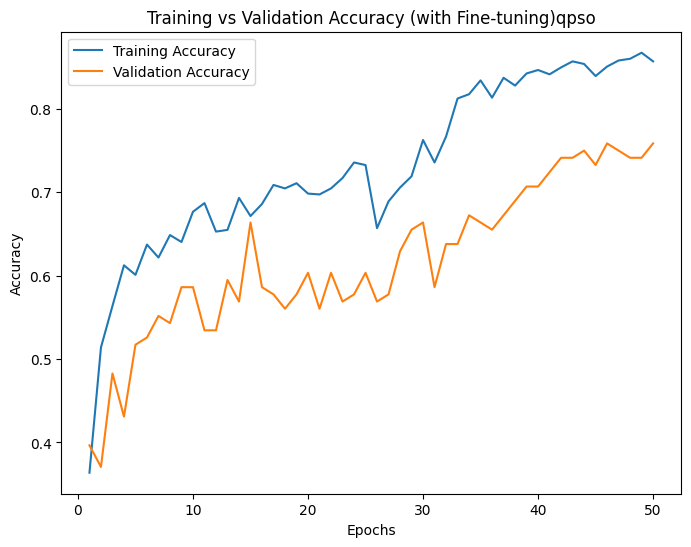

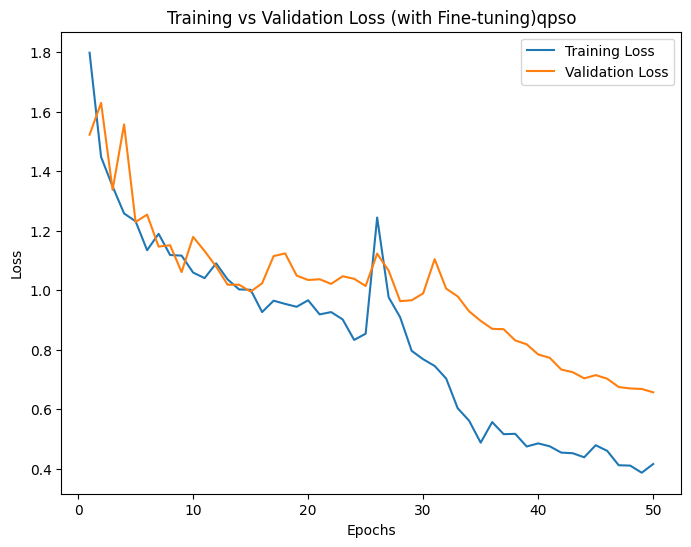

In [ ]:
import matplotlib.pyplot as plt

# Merge history and fine-tuning history
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (with Fine-tuning)qpso')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (with Fine-tuning)qpso')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/Dataset/best_qpso_model.h5')


Saving Screenshot 2025-09-21 233831.png to Screenshot 2025-09-21 233831.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


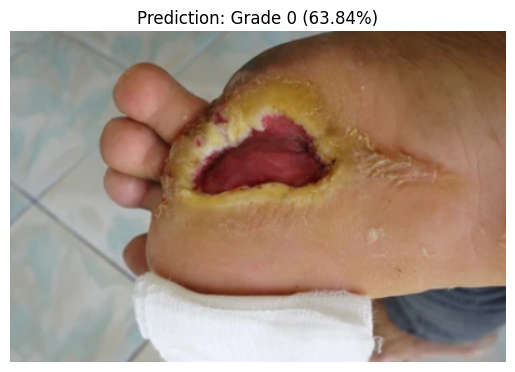

In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = best_qpso_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

In [ ]:
model.save('best_qpso_model.h5')

from google.colab import files
files.download('best_qpso_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>